### LASSO parameter range experiments, summary across all genes

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
base_results_dir = os.path.join(
    cfg.repo_root, '02_cancer_type_classification', 'results', 'lasso_range_valid'
)

training_dataset = 'all_other_cancers'
results_dir = os.path.join(base_results_dir, training_dataset)

metric = 'aupr'

output_plots = True
output_plots_dir = cfg.cancer_type_lasso_range_dir

### Get coefficient information for each lasso penalty

In [3]:
nz_coefs_df = []

# get pancancer coefs info for now
for coef_info in au.generate_nonzero_coefficients_lasso_range(results_dir):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
nz_coefs_df = pd.DataFrame(
    nz_coefs_df,
    columns=['gene', 'cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
print(nz_coefs_df.shape)
print(nz_coefs_df.gene.unique())
nz_coefs_df.head()

(13200, 6)
['TP53' 'BRAF' 'ARID2' 'JAK3' 'H3F3A' 'CDKN2A' 'FLT3' 'CREBBP' 'FOXL2'
 'BCOR' 'ERBB2' 'ARID1A' 'KDM6A' 'ARID1B' 'FGFR2' 'FBXW7' 'EGFR' 'APC'
 'EP300' 'ATRX' 'HRAS' 'GNAS' 'CTNNB1' 'DNMT1' 'GATA2' 'CARD11' 'KIT'
 'ATM' 'CDH1' 'BAP1' 'BRCA2' 'CASP8' 'KRAS']


,gene,cancer_type,lasso_param,seed,fold,nz_coefs
0,TP53,UCEC,0.00025,42,0,6882
1,TP53,UCEC,0.00025,42,1,6827
2,TP53,UCEC,0.00025,42,2,6923
3,TP53,UCEC,0.00025,42,3,6898
4,TP53,LUAD,0.0005,1,0,6143


### Get performance information for each lasso penalty

In [4]:
perf_df = au.load_prediction_results_lasso_range(results_dir, training_dataset)

print(perf_df.shape)
print(perf_df.gene.unique())
perf_df.head()

(39600, 10)
['TP53' 'BRAF' 'ARID2' 'JAK3' 'H3F3A' 'CDKN2A' 'FLT3' 'CREBBP' 'FOXL2'
 'BCOR' 'ERBB2' 'ARID1A' 'KDM6A' 'ARID1B' 'FGFR2' 'FBXW7' 'EGFR' 'APC'
 'EP300' 'ATRX' 'HRAS' 'GNAS' 'CTNNB1' 'DNMT1' 'GATA2' 'CARD11' 'KIT'
 'ATM' 'CDH1' 'BAP1' 'BRCA2' 'CASP8' 'KRAS']


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,experiment,lasso_param
0,0.661710,0.63834,TP53,OV,signal,42,train,0,all_other_cancers,0.1
1,0.089431,0.84457,TP53,OV,signal,42,test,0,all_other_cancers,0.1
2,0.668130,0.60945,TP53,OV,signal,42,cv,0,all_other_cancers,0.1
3,0.685860,0.62514,TP53,OV,signal,42,train,1,all_other_cancers,0.1
4,0.666670,0.97639,TP53,OV,signal,42,test,1,all_other_cancers,0.1


### Compare feature selection with performance

In [5]:
coefs_perf_df = (nz_coefs_df
    .rename(columns={'cancer_type': 'holdout_cancer_type'})
    .merge(perf_df[perf_df.signal == 'signal'],
           on=['gene', 'holdout_cancer_type', 'seed', 'fold', 'lasso_param'])
    .drop(columns=['signal'])
)

coefs_perf_df.head()

,gene,holdout_cancer_type,lasso_param,seed,fold,nz_coefs,auroc,aupr,data_type,experiment
0,TP53,UCEC,0.00025,42,0,6882,0.99924,0.99898,train,all_other_cancers
1,TP53,UCEC,0.00025,42,0,6882,0.89719,0.87748,test,all_other_cancers
2,TP53,UCEC,0.00025,42,0,6882,0.87192,0.84983,cv,all_other_cancers
3,TP53,UCEC,0.00025,42,1,6827,0.99875,0.99850,train,all_other_cancers
4,TP53,UCEC,0.00025,42,1,6827,0.89358,0.80434,test,all_other_cancers


,gene,holdout_cancer_type,lasso_param,seed,fold,nz_coefs,auroc,aupr,data_type,experiment
32259,ATM,LUAD,0.1,1,1,0,0.50000,0.077099,train,all_other_cancers
32260,ATM,LUAD,0.1,1,1,0,0.50000,0.059322,test,all_other_cancers
32261,ATM,LUAD,0.1,1,1,0,0.50000,0.086758,cv,all_other_cancers
9252,CDKN2A,SARC,0.1,42,0,1,0.46537,0.319060,train,all_other_cancers
35710,BRCA2,LUSC,0.1,1,3,1,0.48718,0.135890,test,all_other_cancers
35709,BRCA2,LUSC,0.1,1,3,1,0.59669,0.110480,train,all_other_cancers
9254,CDKN2A,SARC,0.1,42,0,1,0.45874,0.304710,cv,all_other_cancers
9253,CDKN2A,SARC,0.1,42,0,1,0.37778,0.256100,test,all_other_cancers


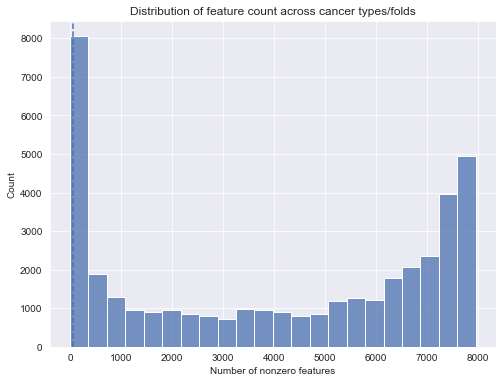

In [6]:
sns.set({'figure.figsize': (8, 6)})

sns.histplot(coefs_perf_df.nz_coefs)
plt.gca().axvline(coefs_perf_df.nz_coefs.quantile(q=0.1), linestyle='--')
plt.title('Distribution of feature count across cancer types/folds')
plt.xlabel('Number of nonzero features')

coefs_perf_df.loc[coefs_perf_df.nz_coefs.sort_values()[:8].index, :]

In [7]:
# look at correlation for each cancer type individually
# positive correlation => more features, better performance
corr_cancer_type_df = []
nz_coefs_cutoff = coefs_perf_df.nz_coefs.quantile(q=0.1)

if nz_coefs_cutoff is not None:
    coefs_perf_df = coefs_perf_df[coefs_perf_df.nz_coefs > nz_coefs_cutoff].copy()

for gene in coefs_perf_df.gene.unique():
    for cancer_type in coefs_perf_df.holdout_cancer_type.unique():
        corr_df = coefs_perf_df[
            (coefs_perf_df.gene == gene) &
            (coefs_perf_df.holdout_cancer_type == cancer_type) &
            (coefs_perf_df.data_type == 'test')
        ]
        try:
            r, p = pearsonr(corr_df.nz_coefs.values, corr_df.aupr.values)
        except ValueError:
            # this happens when the model wasn't trained on the cancer type
            # for the given gene, just skip
            continue
        corr_cancer_type_df.append(
            [gene, cancer_type, r, p]
        )
    
corr_cancer_type_df = pd.DataFrame(
    corr_cancer_type_df,
    columns=['gene', 'cancer_type', 'pearson_r', 'pearson_pval']
).sort_values(by='pearson_r', ascending=False)

print(corr_cancer_type_df.shape)
corr_cancer_type_df.head()

(165, 4)


,gene,cancer_type,pearson_r,pearson_pval
84,FBXW7,READ,0.699117,4.281721e-12
39,CDKN2A,GBM,0.688599,4.449063e-11
82,FBXW7,COAD,0.675650,1.019846e-10
66,ARID1A,STAD,0.675561,1.027724e-10
123,CTNNB1,LIHC,0.629856,1.831195e-09


Text(0, 0.5, 'Pearson correlation')

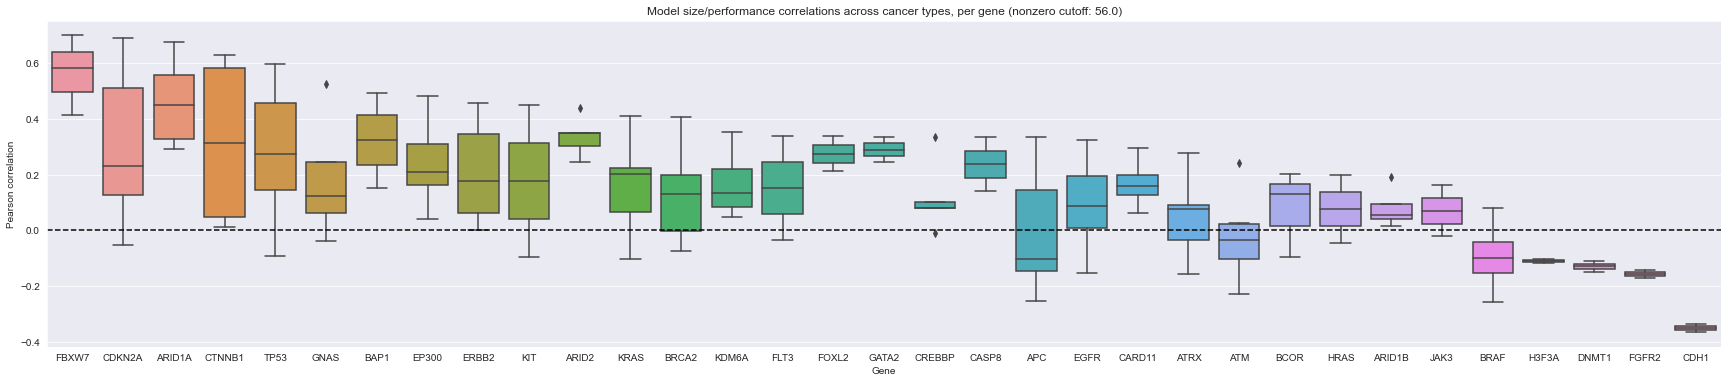

In [8]:
# plot test performance vs. number of nonzero features
sns.set({'figure.figsize': (30, 6)})

ax = sns.boxplot(data=corr_cancer_type_df.sort_values(by='pearson_r', ascending=False), x='gene', y='pearson_r')
ax.axhline(0.0, linestyle='--', color='black')
plt.title(f'Model size/performance correlations across cancer types, per gene (nonzero cutoff: {nz_coefs_cutoff})')
plt.xlabel('Gene')
plt.ylabel('Pearson correlation')

In [9]:
mean_corr_gene_df = (corr_cancer_type_df
    .groupby('gene')
    .agg(np.mean)
    .drop(columns=['pearson_pval'])
)

mean_corr_gene_df.sort_values(by='pearson_r', ascending=False).head()

,pearson_r
gene,
FBXW7,0.567930
ARID1A,0.455026
ARID2,0.336455
BAP1,0.323400
CTNNB1,0.317067


In [10]:
mean_corr_gene_df.sort_values(by='pearson_r', ascending=False).tail()

,pearson_r
gene,
BRAF,-0.095007
H3F3A,-0.110963
DNMT1,-0.129150
FGFR2,-0.156011
CDH1,-0.350983


Text(0, 0.5, 'Gene count')

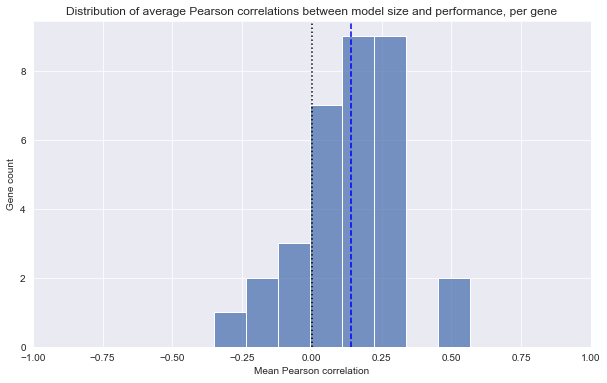

In [11]:
sns.set({'figure.figsize': (10, 6)})

plt.xlim(-1.0, 1.0)
sns.histplot(data=mean_corr_gene_df, x='pearson_r')
plt.axvline(0.0, linestyle=':', color='black')
plt.axvline(mean_corr_gene_df.pearson_r.mean(), linestyle='--', color='blue')
plt.title('Distribution of average Pearson correlations between model size and performance, per gene')
plt.xlabel('Mean Pearson correlation')
plt.ylabel('Gene count')

In [12]:
mean_corr_cancer_type_df = (corr_cancer_type_df
    .groupby('cancer_type')
    .agg(np.mean)
    .drop(columns=['pearson_pval'])
)

mean_corr_cancer_type_df.sort_values(by='pearson_r', ascending=False).head()

,pearson_r
cancer_type,
GBM,0.421717
UCS,0.415211
PAAD,0.340592
TGCT,0.330430
LIHC,0.309494


In [13]:
mean_corr_cancer_type_df.sort_values(by='pearson_r', ascending=False).tail()

,pearson_r
cancer_type,
ESCA,0.069999
SKCM,0.068812
OV,-0.014940
PRAD,-0.023758
THCA,-0.119431


Text(0, 0.5, 'Cancer type count')

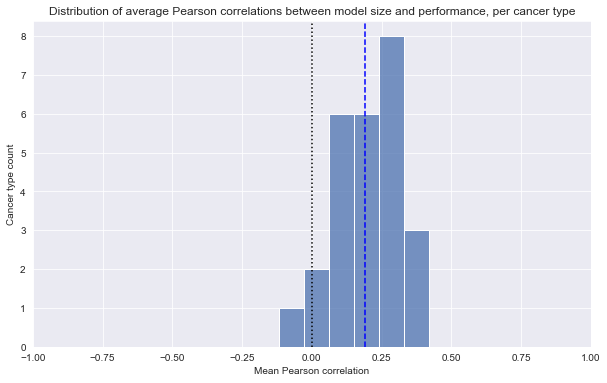

In [14]:
sns.set({'figure.figsize': (10, 6)})

plt.xlim(-1.0, 1.0)
sns.histplot(data=mean_corr_cancer_type_df, x='pearson_r')
plt.axvline(0.0, linestyle=':', color='black')
plt.axvline(mean_corr_cancer_type_df.pearson_r.mean(), linestyle='--', color='blue')
plt.title('Distribution of average Pearson correlations between model size and performance, per cancer type')
plt.xlabel('Mean Pearson correlation')
plt.ylabel('Cancer type count')

This box plot suggests that across these 4 genes, there tends to be a positive correlation between the number of features in the model and generalization performance (i.e. in general, more features in the model => better generalization). 